In [1]:
# Crea escenarios socioeconómicos a
# partir de la identidad de KAYA.

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

In [2]:
path = "../../datos/"
fname = "economic_indicators_1960_2008.csv"

# Columnas para las tasas de crecimiento.
col_t = ["Inicio", "Fin", "Población", "PIB per cápita",
    "Intensidad energética", "Intensidad de carbono",
    "Emisiones de CO2", "Emisiones KAYA"]

datos = pd.read_csv(path + fname, index_col = "Año", skiprows = [1])

# Columnas de los datos históricos.
col_d = datos.columns

# Se agregan los indicadores KAYA a los dato☼ históricos.
datos[col_t[3]] = datos[col_d[1]] / datos[col_d[0]]
datos[col_t[4]] = datos[col_d[2]] / datos[col_d[1]]
datos[col_t[5]] = datos[col_d[3]] / datos[col_d[2]]

# Se actualizan las columnas de los datos históricos.
col_d = datos.columns

datos.head()

,Población,PIB real,Energía primaria,Emisiones de CO2,PIB per cápita,Intensidad energética,Intensidad de carbono
Año,,,,,,,
1960,3009885569,8.750000e+12,1834017.812,9.060156e+06,2907.087263,2.096020e-07,4.940059
1961,3051183165,9.080000e+12,1880521.015,9.057335e+06,2975.894762,2.071058e-07,4.816397
1962,3104591164,9.610000e+12,1983346.682,9.375305e+06,3095.415626,2.063836e-07,4.727013
1963,3169942925,1.010000e+13,2109888.633,9.911853e+06,3186.177240,2.088999e-07,4.697808
1964,3235720397,1.070000e+13,2207318.057,1.041968e+07,3306.837021,2.062914e-07,4.720518


In [3]:
# Tasas de crecimiento.
# i =
#    0: promedio de todo el periodo histórico.
#    1: promedio a utilizar para proyección.
#    2: periodo a proyectar.
#    3: variación de la tasa proyectada.
periodos = np.array([
    (1960, 2008),
    (1971, 2008),
    (2009, 2100),
    (np.nan, np.nan)
    ])

# Se crea un DataFrame vacío.
tasa = pd.DataFrame(
    np.full((periodos.shape[0], len(col_t)),
    fill_value = np.nan), columns = col_t)

# Se llena la fecha de los periodos históricos.
for i in range(0, tasa.shape[0] - 2):
    tasa.iat[i, 0] = periodos[i, 0]
    tasa.iat[i, 1] = periodos[i, 1]

# Se calcula la tasa de crecimiento en el periodo dado.
for i in range(2, tasa.shape[1] - 1):
    tasa.loc[0:1, col_t[i]] = (
        ( datos.loc[tasa.loc[0:1, col_t[1]], col_t[i]].array
        / datos.loc[tasa.loc[0:1, col_t[0]], col_t[i]].array )
        ** ( 1 /  ( tasa.iloc[:-2,1 ].array - 
        tasa.iloc[:-2, 0].array + 1) ) - 1 )

# Se establece la tasa de crecimiento futuro.
i = tasa.shape[0] - 2
tasa.loc[i] = [periodos[i, 0], periodos[i, 1], 
    tasa.iat[i - 1, 2] * 0.95, tasa.iat[i - 1, 3],
    tasa.iat[i - 1, 4], tasa.iat[i - 1, 5], np.nan, 0]

# Se establece la variación en la tasa de crecimiento.
i = tasa.shape[0] - 1
tasa.loc[i] = [np.nan, np.nan, 0.96, 1.00, 
    1.01, 1.01, np.nan, np.nan]

# Se calcula la tasa de emisiones KAYA.
for i in range(0, tasa.shape[0] - 1):
    tasa.iat[i, len(col_t) - 1] = (
        tasa.iloc[i, 2:(len(col_t) - 2)].sum())

tasa.head()

,Inicio,Fin,Población,PIB per cápita,Intensidad energética,Intensidad de carbono,Emisiones de CO2,Emisiones KAYA
0,1960.0,2008.0,0.016351,0.020556,0.001324,-0.013467,0.024629,0.024764
1,1971.0,2008.0,0.015310,0.016038,-0.010424,-0.002407,0.018384,0.018518
2,2009.0,2100.0,0.014545,0.016038,-0.010424,-0.002407,NaN,0.017752
3,NaN,NaN,0.960000,1.000000,1.010000,1.010000,NaN,NaN


In [4]:
# Se crea una DataFrame con el tamaño requerido para
# los datos proyectados.
proyeccion = pd.DataFrame(
    np.zeros((int(periodos[2, 1] - periodos[2, 0] + 2),
    len(col_d))), columns = col_d,
    index = range(int(periodos[2, 0] - 1),
    int(periodos[2, 1] + 1)) )
proyeccion.index.rename("Año", inplace = True)

# Se toman las columnas que se calculan directamente de
# las tasas de crecimiento.
cols = col_t[2:-2]

# Se copia el valor inicial.
proyeccion.loc[periodos[2, 0] - 1] = datos.loc[periodos[2, 0] - 1]

# Se proyectan los datos de acuerdo a las tasas de
# crecimiento.
proyeccion.loc[periodos[2, 0]:, cols] = (
    proyeccion.loc[2008, cols].array * ( 1 + 
    np.expand_dims(tasa.loc[tasa.shape[0] - 2, cols], 0) * (
    np.expand_dims(tasa.loc[tasa.shape[0] - 1, cols], 0) **
    np.expand_dims((proyeccion.loc[periodos[2, 0]:].index.array
    - proyeccion.index[0]), 1) )
    ).cumprod(axis = 0)
    )

# Se proyectan las emisiones a partir de la identidad
# de KAYA.
proyeccion.loc[periodos[2, 0]:, "Emisiones de CO2"] = (
    proyeccion.loc[2008, "Emisiones de CO2"] * ( 1 + ( 
    np.expand_dims(tasa.loc[tasa.shape[0] - 2, cols], 0) * (
    np.expand_dims(tasa.loc[tasa.shape[0] - 1, cols], 0) **
    np.expand_dims((proyeccion.loc[periodos[2, 0]:].index.array
    - proyeccion.index[0]), 1) ) ).sum(axis = 1)
    ).cumprod(axis = 0)
    )

# Se calcula el PIB real y la energía primaria.
proyeccion.loc[periodos[2, 0]:, "PIB real"] = (
    proyeccion.loc[periodos[2, 0]:, "PIB per cápita"] * 
    proyeccion.loc[periodos[2, 0]:, "Población"] )
proyeccion.loc[periodos[2, 0]:, "Energía primaria"] = (
    proyeccion.loc[periodos[2, 0]:, "Intensidad energética"] * 
    proyeccion.loc[periodos[2, 0]:, "PIB real"] )

proyeccion

,Población,PIB real,Energía primaria,Emisiones de CO2,PIB per cápita,Intensidad energética,Intensidad de carbono
Año,,,,,,,
2008,6.663491e+09,5.250000e+13,1.174109e+07,2.984734e+07,7878.753606,2.236398e-07,2.542127
2009,6.756532e+09,5.408681e+13,1.196861e+07,3.035599e+07,8005.115218,2.212852e-07,2.535947
2010,6.847098e+09,5.569090e+13,1.219253e+07,3.085243e+07,8133.503452,2.189322e-07,2.529721
2011,6.935207e+09,5.731221e+13,1.241273e+07,3.133641e+07,8263.950812,2.165809e-07,2.523448
2012,7.020881e+09,5.895076e+13,1.262911e+07,3.180770e+07,8396.490323,2.142316e-07,2.517128
...,...,...,...,...,...,...,...
2096,9.345246e+09,2.986306e+14,1.508692e+07,2.790802e+07,31955.345888,5.052033e-08,1.807395
2097,9.348839e+09,3.035368e+14,1.494724e+07,2.749822e+07,32467.854493,4.924359e-08,1.796849
2098,9.352290e+09,3.085188e+14,1.480479e+07,2.708545e+07,32988.582852,4.798666e-08,1.786260


Text(0.5, 0.95, '1971 - 2008 (1971 = 1)')

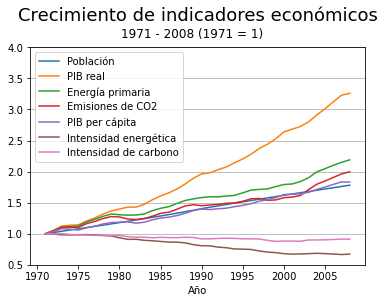

In [5]:
# Se crea una lista para guardar los valores normailzados.
crecimiento = [None] * 3

# Se grafica el periodo histórico.
i = 0

# Se normalizan los datos con respecto al año inicial.
crecimiento[i] = datos.loc[periodos[1, 0]:] / datos.loc[periodos[1, 0]]

# Se crea la gráfica.
crecimiento[i].plot(yticks = np.linspace(
    0.5, 4.5, 8, endpoint = False))
plt.grid(axis = "y")
plt.title("Crecimiento de indicadores económicos\n",
    fontsize = "18")
plt.suptitle(str(int(periodos[1, 0])) + " - " +
    str(int(periodos[1, 1])) + " (" + str(int(periodos[1, 0]))
    + " = 1)", fontsize = "12", y = 0.95)

Text(0.5, 0.95, '2008 - 2100 (2008 = 1)')

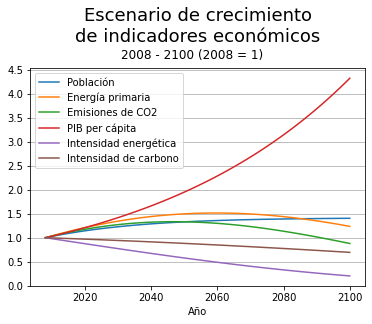

In [6]:
# Se grafica el periodo proyectado.

i = 1

# Se normalizan los datos con respecto al año inicial.
crecimiento[i] = ( proyeccion.loc[periodos[2, 0] - 1:]
    / proyeccion.loc[periodos[2, 0] - 1] )

# Se crea la gráfica.
( crecimiento[i].loc[:, col_d.drop("PIB real")]
    .plot(yticks = np.linspace(0, 5, 10, endpoint = False)) )
plt.grid(axis = "y")
plt.title("Escenario de crecimiento\n" +
    "de indicadores económicos\n", fontsize = "18")
plt.suptitle(str(int(periodos[2, 0]) - 1) + " - " +
    str(int(periodos[2, 1])) + " (" + str(int(periodos[2, 0]) - 1)
    + " = 1)", fontsize = "12", y = 0.95)

Text(0.5, 0.95, '2008 - 2100 (2008 = 1)')

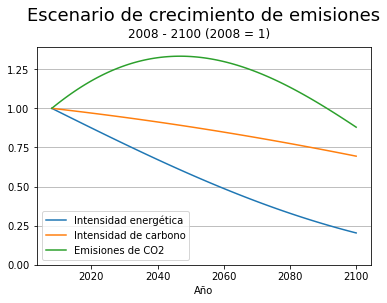

In [7]:
# Se grafica únicamente las tasas de crecimiento e
# intensidades para una mejor lectura.

i = 1

# Se crea la gráfica.
( crecimiento[i].loc[:, ["Intensidad energética",
    "Intensidad de carbono", "Emisiones de CO2"]]
    .plot(yticks = np.linspace(0, 1.5, 6, endpoint = False)) )
plt.grid(axis = "y")
plt.title("Escenario de crecimiento de emisiones\n",
    fontsize = "18")
plt.suptitle(str(int(periodos[2, 0]) - 1) + " - " +
    str(int(periodos[2, 1])) + " (" + str(int(periodos[2, 0]) - 1)
    + " = 1)", fontsize = "12", y = 0.95)

Text(0.5, 0.95, '1971 - 2100 (1971 = 1)')

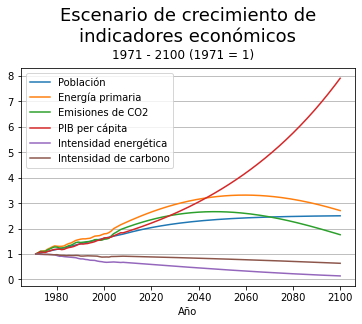

In [8]:
# Se grafican ambo☼ periodos
i = 2

# Se normalizan los datos con respecto al año inicial.
crecimiento[i] = ( pd.concat([datos.loc[periodos[1, 0]:],
    proyeccion.loc[periodos[2, 0]:]], axis = 0)
    / datos.loc[periodos[1, 0]])

# Se crea la gráfica.
( crecimiento[i].loc[:, col_d.drop("PIB real")]
    .plot(yticks = np.linspace(0, 9, 9, endpoint = False)) )
plt.grid(axis = "y")
plt.title("Escenario de crecimiento de\n"
    + "indicadores económicos\n",
    fontsize = "18")
plt.suptitle(str(int(periodos[1, 0])) + " - " +
    str(int(periodos[2, 1])) + " (" + str(int(periodos[1, 0]))
    + " = 1)", fontsize = "12", y = 0.95)